# Attempt with sklearn's MLPClassifier

In [2]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from matplotlib import pyplot as plt
import os
from multiprocessing import Pool

In [3]:
my_path = str(os.getcwd())
X_train = np.load(my_path+'/.data/X_train_surge_new.npz')
X_train_slp = X_train['slp']
X_train_surge1 = X_train['surge1_input']
X_train_surge2 = X_train['surge2_input']
X_train_surge = [None,X_train_surge1,X_train_surge2]
Y_train = np.array(pd.read_csv(my_path+'/.data/Y_train_surge.csv'))
X_test = np.load(my_path+'/.data/X_test_surge_new.npz')

In [4]:
def surge_prediction_metric(dataframe_y_true, dataframe_y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_columns = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_columns = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (weights * (dataframe_y_true[surge1_columns].values - dataframe_y_pred[surge1_columns].values)**2).mean()
    surge2_score = (weights * (dataframe_y_true[surge2_columns].values - dataframe_y_pred[surge2_columns].values)**2).mean()

    return surge1_score + surge2_score

def metric_one_surge(y_true,y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    score = (weights*(y_true-y_pred)**2).mean()
    return score

### Utilitary functions for ruling 'weights' issue

In [5]:
# should be applied to Y_train before learning
def transform(y):
    weights = np.sqrt(np.linspace(1, 0.1, 10)[np.newaxis])
    return weights*y

# should be applied to Y_pred after test
def inverse_transform(y):
    weights = 1/np.sqrt(np.linspace(1, 0.1, 10)[np.newaxis])
    return weights*y

## Use MLP only on surge levels

**Goal**: Is part surges data enough to predict the tide ?

#### 1. First city:

In [5]:
# Extract 1st city data
surge1_y_train = transform(np.array(Y_train)[:,1:11])

surge1_x_train = np.array(X_train['surge1_input'])

surge1_x_test = np.array(X_test['surge1_input'])

In [6]:
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=(10,), alpha=1e-5, random_state=1)
clf.fit(surge1_x_train, surge1_y_train)
surge1_y_test = clf.predict(surge1_x_test)

#### 2. Second city:

In [7]:
# Extract 2nd city data
surge2_y_train = transform(np.array(Y_train)[:,11:])

surge2_x_train = np.array(X_train['surge2_input']) 

surge2_x_test = np.array(X_test['surge2_input'])

In [8]:
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=(10,), alpha=1e-5, random_state=1)
clf.fit(surge2_x_train, surge2_y_train)
surge2_y_test = clf.predict(surge2_x_test)

Result of this method: 0.88

Pretty bad, it shows that we need the information of the slp

## Take into account slp

### 1. Dimension reduction of slp data (using PCA)

In [6]:
def slp_to_flat_images(slp):
    a,b,c,d = np.shape(slp)
    return slp.reshape((a*b,c*d))

class Preprocess:
    
    _pca = PCA()
    _scaler1 = StandardScaler()
    _scaler2 = StandardScaler()
    
    def fit_transform(self,slp,nb_comp):
        #reshape
        list_flat_images = slp_to_flat_images(slp)
        # print(list_flat_images.shape)
        #normalize
        list_flat_images = self._scaler1.fit_transform(list_flat_images)
        #fit PCA and transform
        self._pca = PCA(n_components=nb_comp)
        slp_LD = self._pca.fit_transform(list_flat_images)
        #reshape
        slp_LD = np.array([np.concatenate(slp_LD[i*40:(i+1)*40]) for i in range(len(slp))])
        #renormalize
        slp_LD = self._scaler2.fit_transform(slp_LD)
        return slp_LD
    
    def transform(self,slp):
        flat = slp_to_flat_images(slp)
        flat = self._scaler1.transform(flat)
        slp_LD = self._pca.transform(flat)
        slp_LD = np.array([np.concatenate(slp_LD[i*40:(i+1)*40]) for i in range(len(slp))])
        slp_LD = self._scaler2.transform(slp_LD)
        # print(slp_LD.shape)
        # print(slp_LD.shape)
        return slp_LD

In [18]:
prepro = Preprocess()
slp_train_LD = prepro.fit_transform(X_train['slp'], 4)
print(slp_train_LD.shape)

(5599, 160)


In [19]:
slp_test_LD = prepro.transform(X_test['slp'])

### 2. Cross validation

cross validating for one city at a time as we train different models for both

Hyperparameters to test (ordered by priority):
- learning rate
- activation function
- number of dimensions to which we reduce the slp images
- hidden layer size (if we follow the rule of thumb this would be 1 layer with (size(input)+size(output))/2 neurons)

Be carefull to do the preprocess after having split the data into train/test

In [9]:
# prepare validation dataset (extract test from the data we have)
nbs = 10 #number of splits to do the average on
test_s = 0.1 # size of test sample
ss = ShuffleSplit(n_splits=nbs,test_size=test_s)
X_ind = np.zeros(5599)

# function to call for cross validate a parameter
def testParams(city=1, learningRate=1e-5, dimPCA=4, hiddenLayers=(100,),slv='sgd',activ_fun='relu'):
    
    errors = []
    
    for s, (train_index, test_index) in enumerate(ss.split(X_ind)):
        print(s)
        #split data
        slp_train = X_train_slp[train_index]
        slp_test = X_train_slp[test_index]
        
        surge_input_train = X_train_surge[city][train_index]
        surge_input_test = X_train_surge[city][test_index]
        
        surge_output_train = Y_train[train_index,1:11] if city==1 else Y_train[train_index,11:]
        surge_output_test = Y_train[test_index,1:11] if city==1 else Y_train[test_index,11:]
        
        #preprocessing
        prepro = Preprocess()
        slp_train_LD = prepro.fit_transform(slp_train, dimPCA)
        slp_test_LD = prepro.transform(slp_test)
        
        y_train = transform(surge_output_train)
        
        #concatenate slp and surge input
        x_train = np.concatenate((surge_input_train, slp_train_LD), axis=1)
        x_test = np.concatenate((surge_input_test, slp_test_LD), axis=1)
        
        #learn
        clf = MLPRegressor(solver=slv, hidden_layer_sizes=((10+10+40*dimPCA)//2,), alpha=learningRate,max_iter=1000,activation=activ_fun)
        clf.fit(x_train,transform(y_train))
        
        #predict
        y_pred = inverse_transform(clf.predict(x_test))
        
        error = metric_one_surge(surge_output_test,y_pred)
        errors.append(error)
        print("error :",error)
    
    print(learningRate,errors)
    return errors    

#### Learning rate optimisation: (Be careful running this cell is veeery long)

In [15]:
solvers = ['sgd', 'adam']
activ_funs = ['identity', 'logistic', 'tanh', 'relu']
PCAdims = [i for i in range(5,10)]
alpha = [10**-i for i in range(1,10)]
errs = np.array([testParams(city=2,dimPCA=k) for k in PCAdims])
#errs = np.array([testParams(city=2,learningRate=a,slv='adam') for a in alpha])
avgerrs = np.mean(errs,axis=1)

0
error : 0.19865277134121534
1
error : 0.18368712111198285
2
error : 0.19303943768080362
3
error : 0.20269063497304415
4
error : 0.18664653924359653
5
error : 0.20860738024360428
6
error : 0.2035203493486712
7
error : 0.18605999978196527
8
error : 0.19646909224792625
9
error : 0.1712068897661291
1e-05 [0.19865277134121534, 0.18368712111198285, 0.19303943768080362, 0.20269063497304415, 0.18664653924359653, 0.20860738024360428, 0.2035203493486712, 0.18605999978196527, 0.19646909224792625, 0.1712068897661291]
0
error : 0.18647955982377246
1
error : 0.1764504308334965
2
error : 0.18106959563948785
3
error : 0.1645207580221714
4
error : 0.18178505981077672
5
error : 0.18769306628619428
6
error : 0.16995179456754325
7
error : 0.20138959961900207
8
error : 0.18329683489426046
9
error : 0.18168975169162338
1e-05 [0.18647955982377246, 0.1764504308334965, 0.18106959563948785, 0.1645207580221714, 0.18178505981077672, 0.18769306628619428, 0.16995179456754325, 0.20138959961900207, 0.18329683489426

[[0.19865277 0.18368712 0.19303944 0.20269063 0.18664654 0.20860738
  0.20352035 0.18606    0.19646909 0.17120689]
 [0.18647956 0.17645043 0.1810696  0.16452076 0.18178506 0.18769307
  0.16995179 0.2013896  0.18329683 0.18168975]
 [0.21039341 0.18807514 0.17854103 0.17761297 0.19074062 0.17736063
  0.17204364 0.17587884 0.17692903 0.18586713]
 [0.19545189 0.19159399 0.18156903 0.18633314 0.17266853 0.20571806
  0.16467666 0.15501785 0.17443328 0.17621131]
 [0.18654446 0.17452944 0.17728135 0.16722355 0.17065835 0.18968057
  0.18134124 0.17797838 0.19766155 0.1891735 ]]


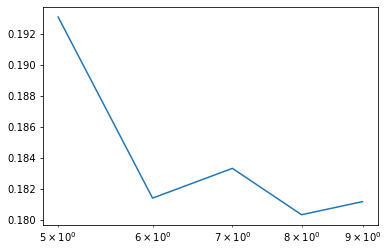

[0.19305802 0.18143265 0.18334424 0.18036737 0.18120724]


In [16]:
print(errs)
plt.xscale('log', base=10)
plt.plot(PCAdims,avgerrs)
plt.show()
print(avgerrs)

Conclusion :

Hyperparameters for city 1 :
- alpha = 1e-5

Hyperparameters for city 2 :
- alpha is basically the same

Identity activation function is better for both

augmenting PCA dimension seems to be better for cross-validation tests, but doesnt translates to a better result on the site...

### 3. Prediction

#### 1. First city:

In [26]:
# Extract 1st city data
surge1_y_train = transform(np.array(Y_train)[:,1:11])

surge1_input = np.array(X_train['surge1_input'])
surge1_x_train = np.concatenate((surge1_input, slp_train_LD), axis=1)

surge1_x_test = np.concatenate((np.array(X_test['surge1_input']), slp_test_LD), axis=1)

print(surge1_x_train)

[[-5.4593754e-01  1.3110517e-01  3.1880018e-01 ...  1.8659165e+00
   2.8711839e+00  1.8419557e-04]
 [ 3.1880018e-01  1.9478741e-01 -2.2752637e-01 ...  2.2618122e+00
   4.3655925e+00  4.0389067e-01]
 [-2.2752637e-01 -4.0181461e-01 -8.7440383e-01 ...  1.2428132e+00
   2.5140035e+00 -3.7171990e-01]
 ...
 [ 5.0984687e-01  8.7518185e-01  1.8505255e+00 ... -8.3915585e-01
   6.7250866e-01 -1.1371883e-01]
 [ 1.8505255e+00  1.1935930e+00  1.3980465e+00 ... -8.7895751e-01
   2.0118426e-01 -1.8728971e-01]
 [ 1.3980465e+00  1.7801399e+00  1.4516736e+00 ... -6.3044600e-02
   1.2727228e+00 -7.1262109e-01]]


In [27]:
dimPCA1 = 6
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=((10+10+40*dimPCA1)//2,), alpha=1e-5,max_iter=1000,activation='identity')
clf.fit(surge1_x_train, surge1_y_train)
surge1_y_test = clf.predict(surge1_x_test)

#### 2. Second city:

In [28]:
# Extract 2nd city data
surge2_y_train = transform(np.array(Y_train)[:,11:])

surge2_input = np.array(X_train['surge2_input'])
surge2_x_train = np.concatenate((surge2_input, slp_train_LD), axis=1)

surge2_x_test = np.concatenate((np.array(X_test['surge2_input']), slp_test_LD), axis=1)

In [29]:
dimPCA2 = 9
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=((10+10+40*dimPCA2)//2,), alpha=1e-5,max_iter=1000,activation='identity')
clf.fit(surge2_x_train, surge2_y_train)
surge2_y_test = clf.predict(surge2_x_test)

Result:

## Generate output

In [30]:
# transform clf output
surge_pred = np.concatenate((inverse_transform(surge1_y_test), inverse_transform(surge2_y_test)), axis=1)

In [31]:
y_columns = [f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)]
Y_pred = pd.DataFrame(data=surge_pred, columns=y_columns, index=X_test['id_sequence'])
Y_pred.to_csv('Y_sep_MLP_id_highPCA.csv', index_label='id_sequence', sep=',')